In [1]:
from data import Data
from dimension_reduction import PCADimensionReduction
from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


2023-01-08 14:50:30.017614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_filepath = "data/by_type/t1/counts_ctc_simulated_123_5k_t1.tsv"
true_results_filepath = "data/by_type/t1/ids_ctc_simulated_123_5k_t1.tsv"
train_indices_filepath = "data/by_type/t1/train_indices.npy"
test_indices_filepath = "data/by_type/t1/test_indices.npy"
SEED = 42
FOLD_NUMBER = 3



# There are 4 data variants to check: regular, scaled, cut by max, pca reduced + cut by max
data_object = Data(data_filepath, true_results_filepath)
train_data, test_data, train_true_results, test_true_results =  data_object.load_train_test_split(train_indices_filepath, test_indices_filepath)
data_object.summary()

Total cells number in train data: 3074
CTC cells number in train data: 35
WBC cells number in train data: 3039

Total cells number in test data: 1318
CTC cells number in test data: 15
WBC cells number in test data: 1303


In [3]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(data_object.train_data, data_object.test_data, 0.5)
print(f"Feature number: {len(cut_by_mean_with_classes_train_data.columns)}")

Feature number: 121


In [4]:
cut_by_mean_train_data, cut_by_mean_test_data = Data.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.3
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = Data.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=3
)
print(f"Feature number: {len(cut_by_mean_max_train_data.columns)}")

Feature number: 173


### LightGBM

In [5]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [6]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 1.0
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 1.0
Training recall 1.0

Validation f1 1.0
Training f1 1.0



In [7]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.9996162701458173

Test roc auc 0.9998635627185127

Test precision 0.9375

Test recall 1.0

Test f1 score 0.967741935483871


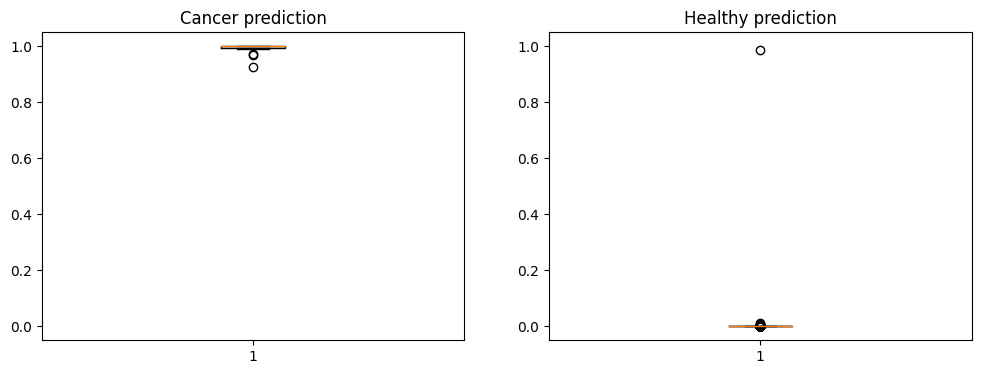

In [8]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

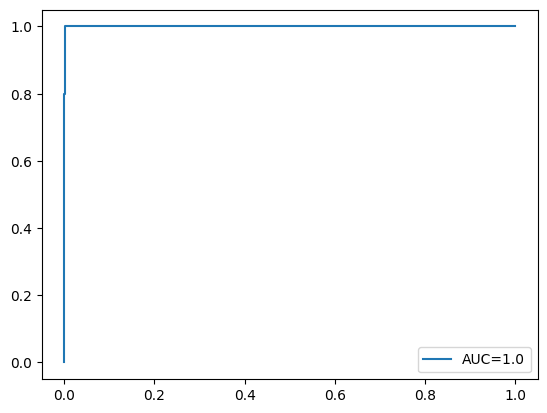

In [9]:
vis.draw_roc_curve_from_probabilities()

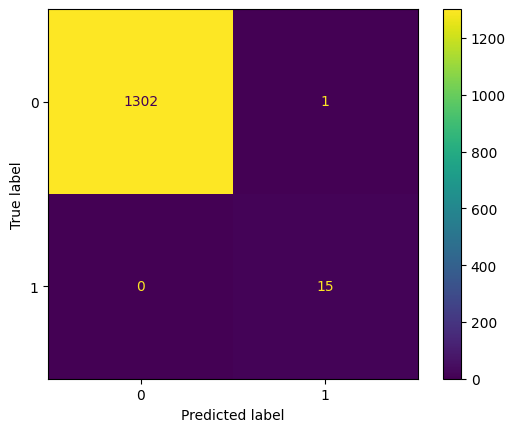

In [10]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [11]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9718931666118241
Training balanced accuracy 1.0

Validation roc auc 0.9997781367475346
Training roc auc 1.0

Validation precision 0.9419191919191919
Training precision 1.0

Validation recall 0.9444444444444445
Training recall 1.0

Validation f1 0.9420289855072465
Training f1 1.0



In [12]:
lgbm_model_object.display_test_results()

Test balanced accuracy 1.0

Test roc auc 1.0

Test precision 1.0

Test recall 1.0

Test f1 score 1.0


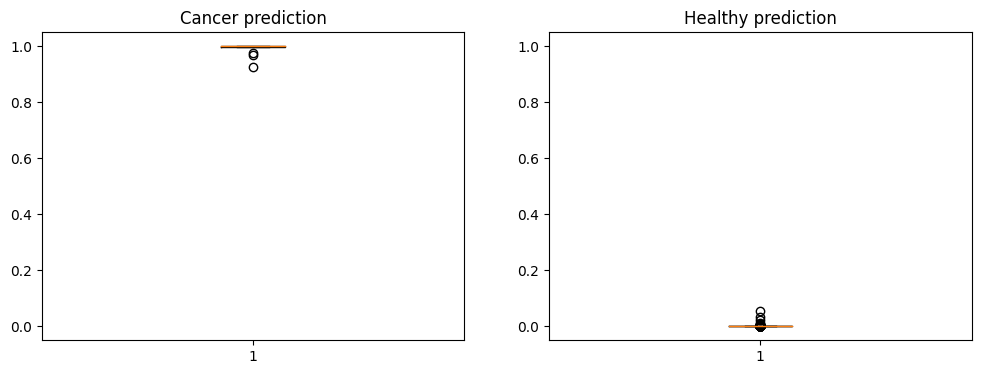

In [13]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

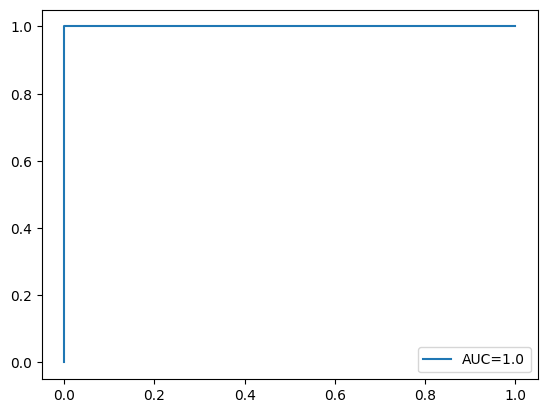

In [14]:
vis.draw_roc_curve_from_probabilities()

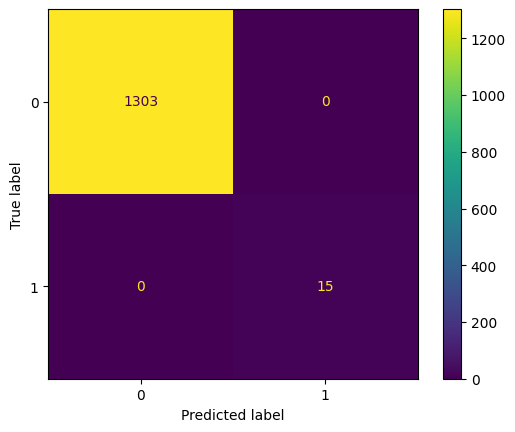

In [15]:
vis.display_confusion_matrix()

### XGBoost

In [16]:
healthy_cells_train_indices = np.where(data_object.train_true_results == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_true_results == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    min_child_weight=48,
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [17]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9712350553910278
Training balanced accuracy 0.9991773609740046

Validation roc auc 0.9999451573982668
Training roc auc 1.0

Validation precision 0.8517482517482518
Training precision 0.8754578754578755

Validation recall 0.9444444444444445
Training recall 1.0

Validation f1 0.89170692431562
Training f1 0.933542647828362



In [18]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.988377249083312

Test roc auc 0.9999829453398141

Test precision 0.9177287581699346

Test recall 0.9777777777777779

Test f1 score 0.9461917562724015


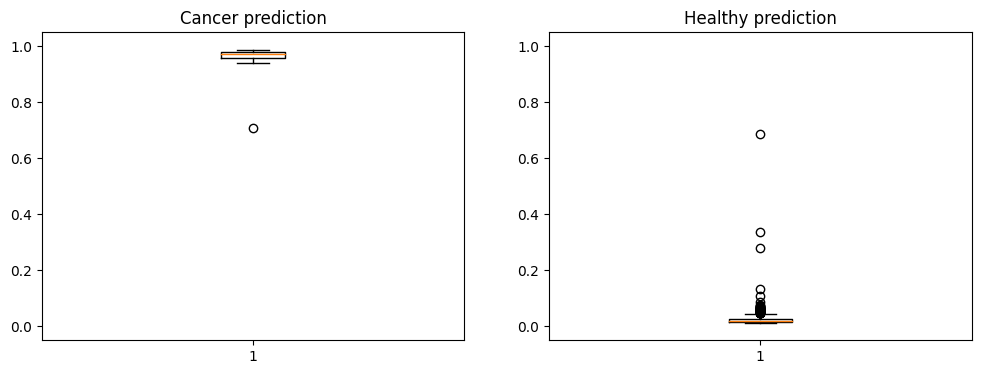

In [19]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

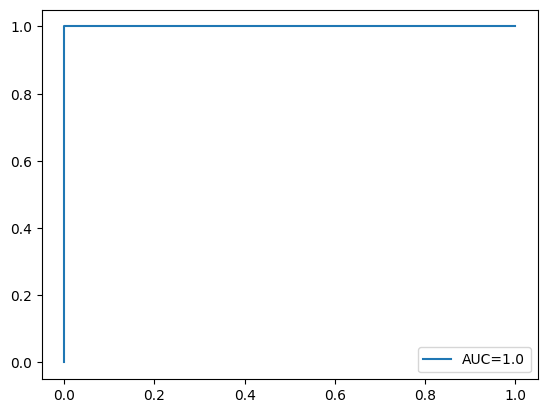

In [20]:
vis.draw_roc_curve_from_probabilities()

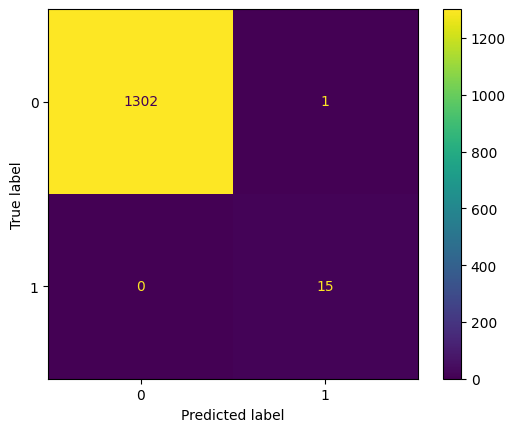

In [21]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [22]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9851239442799166
Training balanced accuracy 0.9990128331688055

Validation roc auc 0.9998304865037343
Training roc auc 1.0

Validation precision 0.8531746031746031
Training precision 0.853615520282187

Validation recall 0.9722222222222222
Training recall 1.0

Validation f1 0.9065811965811966
Training f1 0.9210256410256411



In [23]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9993604502430289

Test roc auc 0.9998976720388847

Test precision 0.9007352941176471

Test recall 1.0

Test f1 score 0.9475806451612904


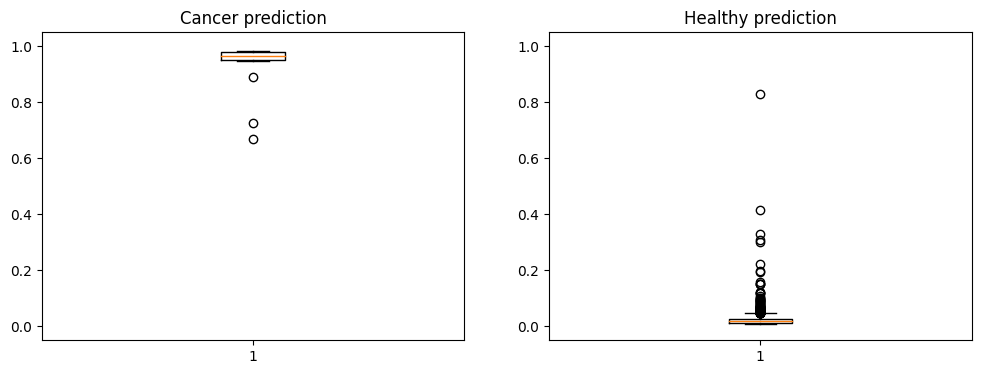

In [24]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

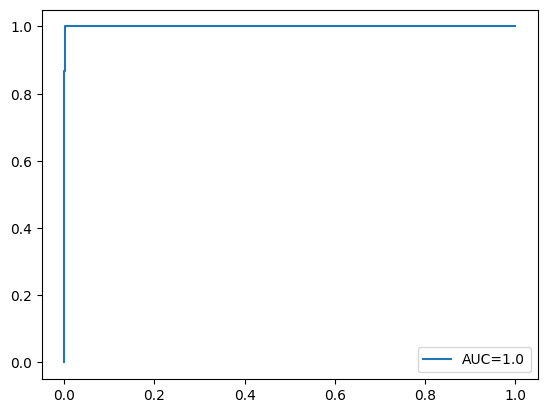

In [25]:
vis.draw_roc_curve_from_probabilities()

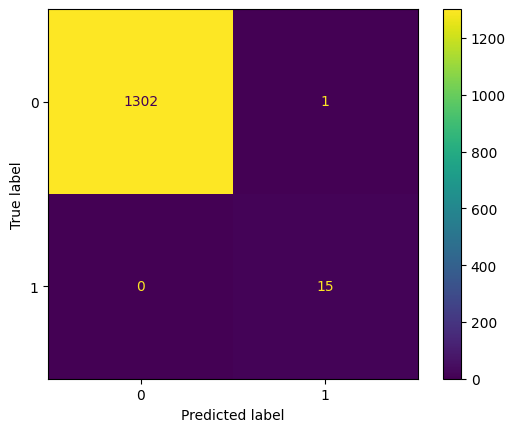

In [26]:
vis.display_confusion_matrix()

### Random Forest

In [27]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [28]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9722222222222223
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9444444444444445
Training recall 1.0

Validation f1 0.9696969696969697
Training f1 1.0



In [29]:
rf_model_object.display_test_results()

Test balanced accuracy 1.0

Test roc auc 1.0

Test precision 1.0

Test recall 1.0

Test f1 score 1.0


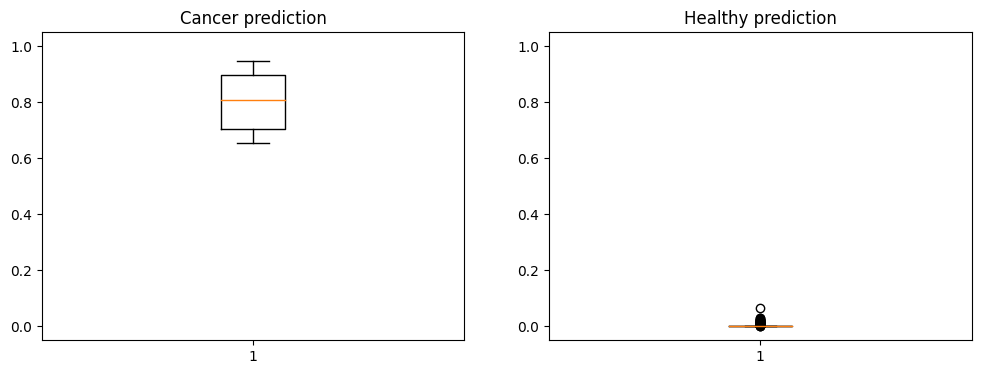

In [30]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

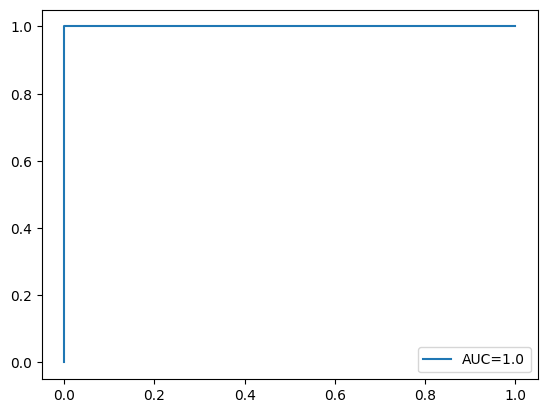

In [31]:
vis.draw_roc_curve_from_probabilities()

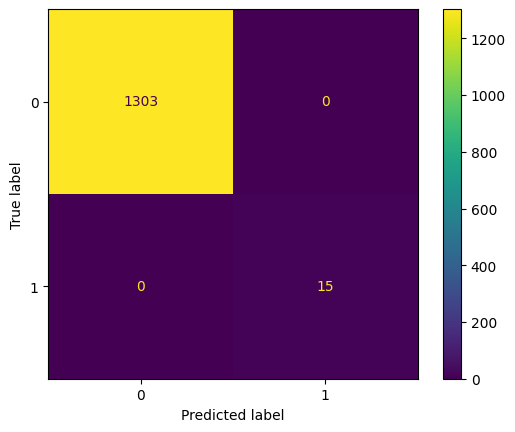

In [32]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [33]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.88510101010101
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.7702020202020202
Training recall 1.0

Validation f1 0.8694463431305537
Training f1 1.0



In [34]:
rf_model_object.display_test_results()

Test balanced accuracy 0.9777777777777779

Test roc auc 1.0

Test precision 1.0

Test recall 0.9555555555555556

Test f1 score 0.9770114942528737


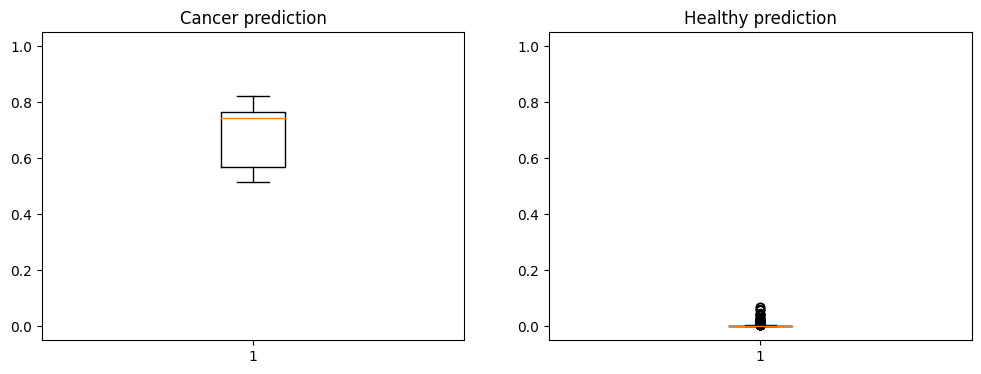

In [35]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

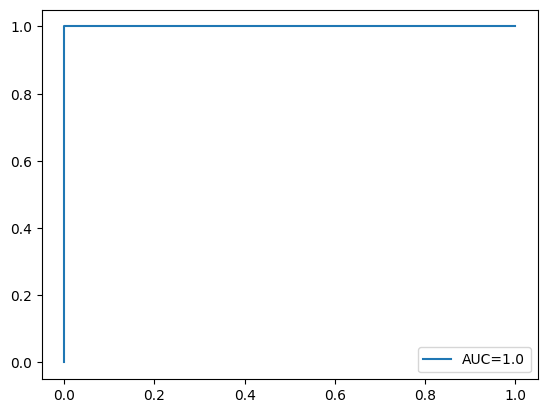

In [36]:
vis.draw_roc_curve_from_probabilities()

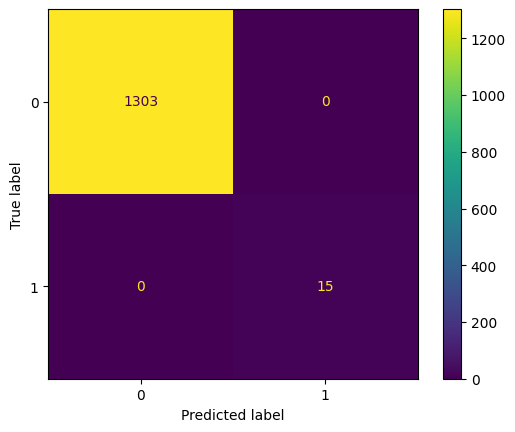

In [37]:
vis.display_confusion_matrix()

### Balanced Random Forest

In [38]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [39]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9993418887792037
Training balanced accuracy 0.9990950970714051

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9010989010989011
Training precision 0.8654524487857822

Validation recall 1.0
Training recall 1.0

Validation f1 0.9465811965811964
Training f1 0.9273202614379086



In [40]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9989767203888462

Test roc auc 1.0

Test precision 0.8496732026143792

Test recall 1.0

Test f1 score 0.9185606060606061


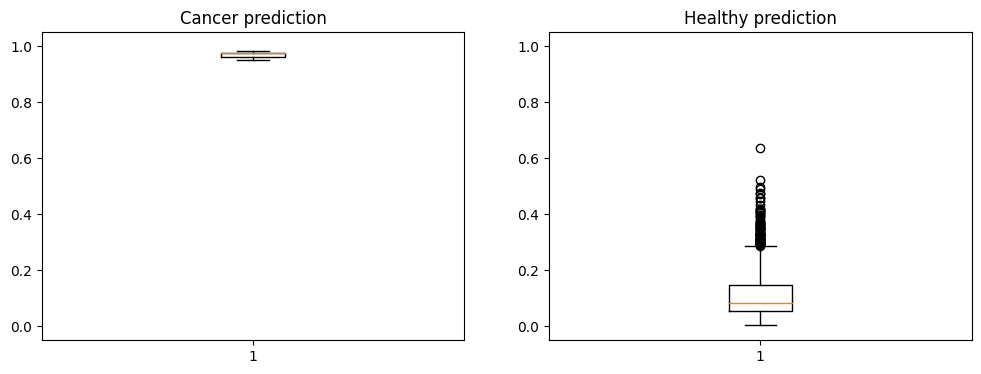

In [41]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

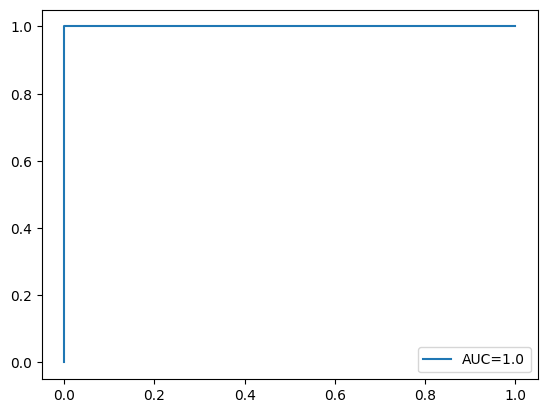

In [42]:
vis.draw_roc_curve_from_probabilities()

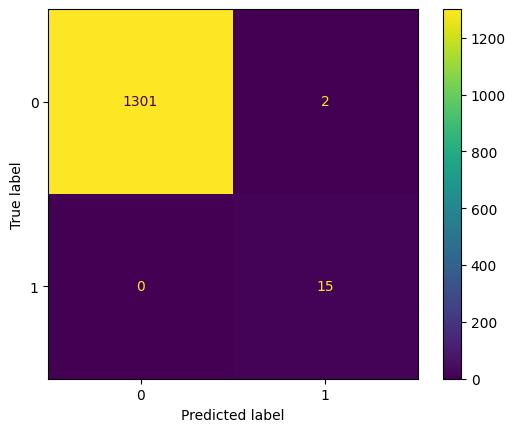

In [43]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [44]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.998025666337611
Training balanced accuracy 0.9984369858506087

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.7514005602240896
Training precision 0.7865900383141762

Validation recall 1.0
Training recall 1.0

Validation f1 0.8553113553113553
Training f1 0.8804762672687202



In [45]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9960347915067792

Test roc auc 1.0

Test precision 0.592948717948718

Test recall 1.0

Test f1 score 0.7442151344590369


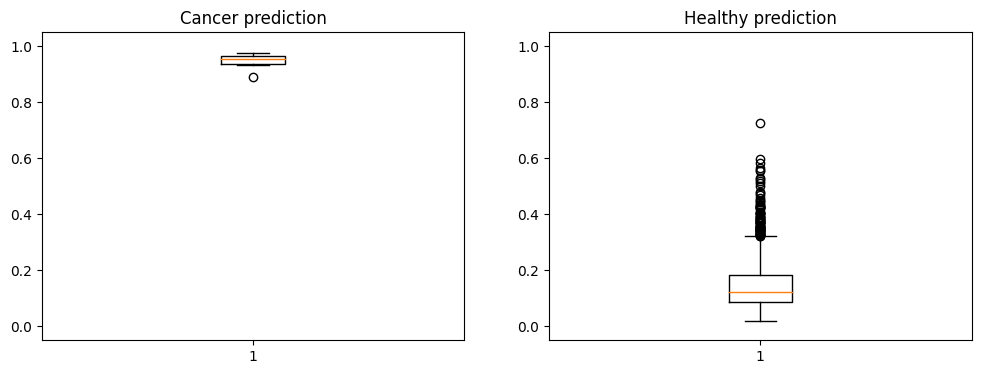

In [46]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

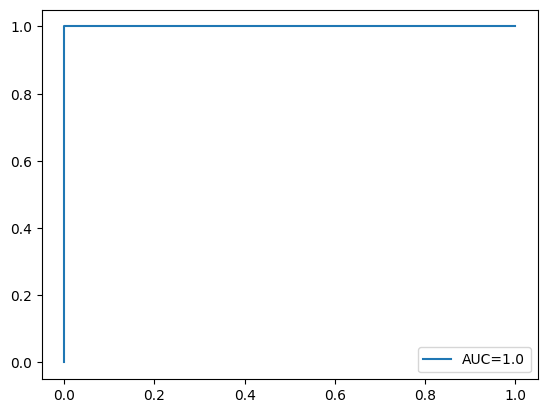

In [47]:
vis.draw_roc_curve_from_probabilities()

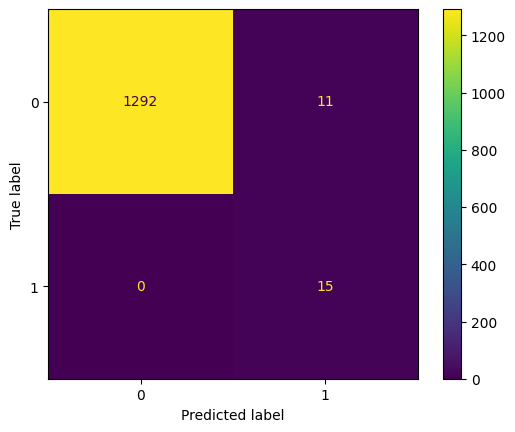

In [48]:
vis.display_confusion_matrix()